In [111]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ISLP import load_data

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline

In [10]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
College = load_data('College')
College.head(5)

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [12]:
College['Private'].unique()

array(['Yes', 'No'], dtype=object)

In [45]:
# Encode Private as 1 (Yes) or 0 (No)
ohe = OneHotEncoder()
r = ohe.fit_transform(College[['Private']])
College['Private'] = r.toarray()
College['Private'] = (College['Private'] == 0).astype('int')
College.head(5)

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,1,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,1,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,1,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,1,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,1,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [46]:
# Separate X (predictors) and y (response)
X = College.drop('Apps', axis=1)
y = College['Apps']

In [115]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1
)

In [123]:
# Fit linear regression model to train, and evaluate in test
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_reg', LinearRegression())
])

kfold = KFold(5, random_state=0, shuffle=True)
param_grid = {'linear_reg__fit_intercept': [True, False]}
grid = GridSearchCV(
    pipe,
    param_grid,
    cv=kfold
)

reg = grid.fit(X_train, y_train)
reg.score(X_test, y_test), reg.score(X_train, y_train)

(0.9549935938442622, 0.9225641321119179)

In [127]:
# The coefficients from Linear Regression
reg.best_score_

0.8916659329194433

In [121]:
# Ridge with cross validation to choose alpha

pipe = Pipeline([
    ('scale', StandardScaler()),
    ('ridge', ElasticNet(alpha=20, l1_ratio=0))
])

kfold = KFold(5, random_state=0, shuffle=True)
lambdas = 10**np.linspace(3, -7, 100)#/y.std()
param_grid = {'ridge__alpha': lambdas, 'ridge__l1_ratio': [0]}
grid = GridSearchCV(
    pipe,
    param_grid,
    #cv=kfold
)

grid.fit(X_train, y_train)

grid.best_estimator_, grid.score(X_test, y_test), grid.score(X_train, y_train)

(Pipeline(steps=[('scale', StandardScaler()),
                 ('ridge', ElasticNet(alpha=0.001747528400007683, l1_ratio=0))]),
 0.9547331163035555,
 0.9225340983472514)

In [ ]:
# Ridge

# Standarize X
Xs = X - X.mean(0)[None, :]
X_scale = X.std(0)
Xs = Xs/X_scale[None, :]

lambdas = 10**np.linspace(8, -2, 100)/y.std()
soln_arr = ElasticNet.path(Xs, y, l1_ratio=0, alphas=lambdas)[1] # The second element are the coefficients along the path

soln_path = pd.DataFrame(
    soln_arr.T,
    columns=Xs.columns,
    index=-np.log(lambdas)
)

path_fig, ax = plt.subplots(figsize=(8,8))
soln_path.plot(ax=ax, legend=False)
ax.legend(loc='upper left');

In [28]:
def find_best_alpha(model, alphas):
    scores = []
    scores_train = []
    # alphas = np.arange(0, 100, 0.5)
    for a in alphas:
        clf = model(alpha=a) # model can be Ridge, Lasso, etc
        scores.append(cross_val_score(clf, X, y, cv=10).mean())
        #scores.append(cross_validate(clf, X, y, cv=10, return_train_score=True)['test_score'].mean())
        #scores_train.append(cross_validate(clf, X, y, cv=10, return_train_score=True)['train_score'].mean())

    # coefs for the best alpha
    best_alpha = alphas[scores.index(max(scores))]
    best_clf = model(alpha=best_alpha).fit(X_train, y_train)

    fig, ax = plt.subplots(figsize=(10,6))
    ax.plot(alphas, scores)
    #ax.plot(alphas, scores_train)
    ax.set_xscale('log')
    #ax.set_ylim([0.9,0.94])
    ax.axvline(best_alpha)
    ax.grid()

    
    return best_clf.coef_, best_alpha

array([-4.05223159e+02,  1.16923348e+00,  2.83621332e-01,  6.00890454e+01,
       -2.28716322e+01,  2.01498633e-02,  4.18510628e-02, -2.65218125e-02,
        2.13506444e-01, -1.01849104e-02, -2.82492601e-03, -4.08810803e+00,
       -5.98178528e+00,  7.88971413e+00, -8.74551720e+00,  4.28325925e-02,
        7.27172578e+00])

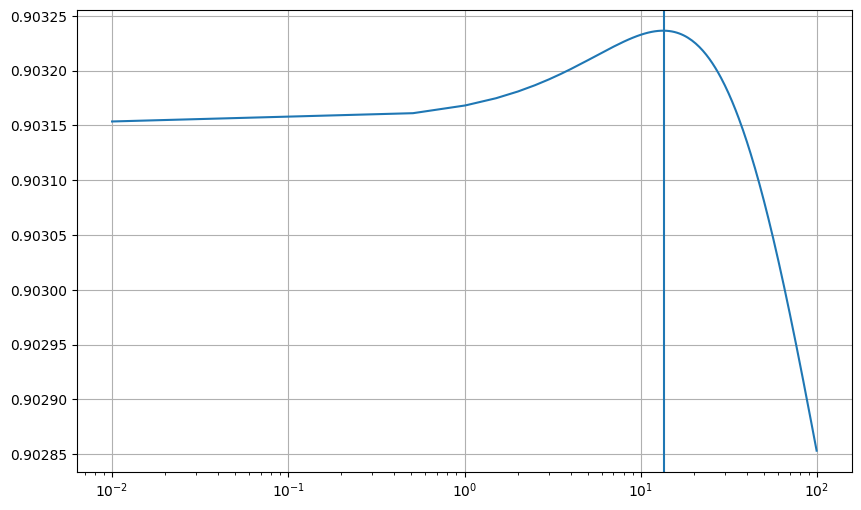

In [29]:
ridge_coefs, _ = find_best_alpha(Ridge, np.arange(0.01, 100, 0.5))
ridge_coefs

(array([-4.66345762e+02,  1.16837814e+00,  2.83402203e-01,  5.99110663e+01,
        -2.27211905e+01,  1.86668007e-02,  4.09971945e-02, -2.41715450e-02,
         2.16536361e-01, -6.51296513e-03, -2.39566614e-03, -4.29791138e+00,
        -6.15974593e+00,  6.24828633e+00, -8.40250879e+00,  4.22678909e-02,
         7.29432010e+00]),
 7.01)

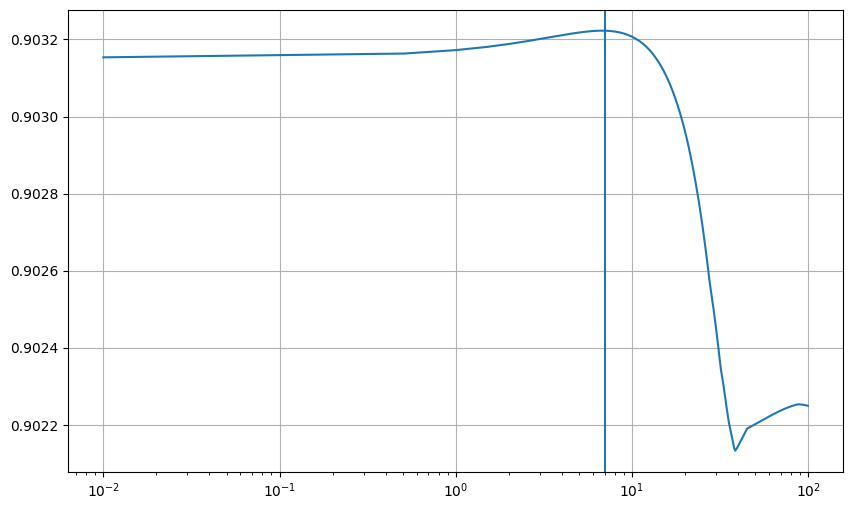

In [30]:
lasso_coefs, best_alpha_lasso = find_best_alpha(Lasso, np.arange(0.01, 100, 0.5))
lasso_coefs, best_alpha_lasso

In [31]:
for a, b, c in zip(lreg_coefs, ridge_coefs, lasso_coefs):
    print(a,b,c)

-554.8356821682215 -405.2231593436226 -466.3457616222213
1.1659464107487816 1.1692334822112298 1.168378138293223
0.28698140133179434 0.2836213323031759 0.2834022027237486
60.181762910196326 60.08904541716342 59.91106631200163
-22.870340807361554 -22.871632186557147 -22.721190543265127
0.016038040208728052 0.02014986333468163 0.01866680066101134
0.04013954060253787 0.04185106280714097 0.040997194466373954
-0.020099325650293497 -0.026521812452999293 -0.02417154496892707
0.2211822472532767 0.21350644350572834 0.21653636133844534
-0.0022069040778543744 -0.010184910424733311 -0.0065129651333337615
-0.0010864002905395826 -0.002824926009215423 -0.0023956661416632205
-4.729869259021551 -4.088108027351545 -4.297911382375701
-6.447849489111156 -5.981785278394999 -6.159745932350423
6.055875402464364 7.889714130986002 6.2482863334466385
-8.015323872656467 -8.745517202743235 -8.40250878904228
0.04189852834771949 0.04283259252972613 0.042267890886771235
7.41801784496241 7.271725783659139 7.294320104

interc 0.0
slope [0.81081081]
predict at x=0 [0.]


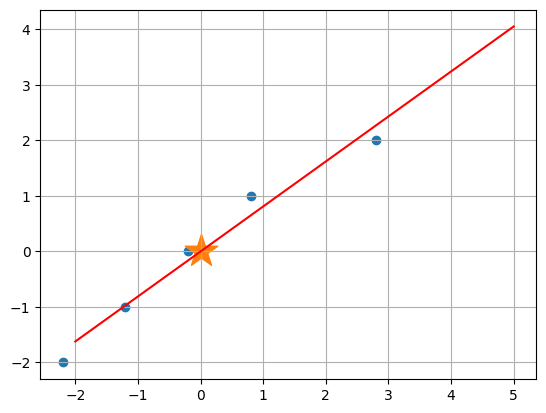

In [23]:
# EXAMPLE
# Scale
from sklearn import linear_model
import numpy as np

x=np.array([-1,0,1,2,4]).reshape((5,1))
x = x-x.mean()
y=np.array([1001,1002,1003,1004,1005,])
y = y-y.mean()
fit=linear_model.Ridge(alpha=0,fit_intercept=False).fit(x,y)

print('interc', fit.intercept_)
print('slope', fit.coef_)
print('predict at x=0', fit.predict(np.array([0]).reshape(-1,1)))

plt.scatter(x,y)

plt.plot(np.linspace(-2, 5, 50), fit.intercept_ + fit.coef_[0]*np.linspace(-2, 5, 50), c='r')
plt.scatter(0, fit.predict(np.array([0]).reshape(-1,1)), marker='*', s=602)
plt.grid()